# Model for Simulating Energy and Economic Performance of Off-Grid PV in DR Aggregations V3.0

In [739]:
import pandas as pd
import numpy as np
import requests
import pvlib
import matplotlib.pyplot as plt  # for visualization
import math
from datetime import datetime
from statistics import median
from statistics import mean
from keys import *
from typing import List, Dict, Any

In [740]:
#GLOBALS
#note that these coordinates are the inputs for the NREL API,
#the coordinates used by the NREL API for the weather file are slightly different
#see below
lat = 40.7128
long = -74.0060

#optimize for summer when DR program is in effect
#also minimizes shading from buildings during PSH
tilt = math.floor(lat - 15)
print("tilt: " + str(tilt))

#default to south facing
azimuth = 180

#14% losses
shading = .86

#max 99% efficient mppt battery charger
mppt = .99

#max 80% depth of discharge for LiFePO4 batteries
LiFePOdod = .8

#Max Hardware Sizes
#800 is in line with German balcony solar policy
pvMaxW = 800
#2kWh is the largest system FDNY allows without additional beurocracy 
#batMaxWh = 2000

#PV degredation rate is assumed to be 1% annually
DEG_RATE = 0.01

#days in the months May - September
daysInMonth = [31,30,31,31,30]
drSeasonStartDay = 121

# self consumption of both controller and power station
controllerSC = 1 #Raspberry Pi Zero 2W controller self-consumption
powerStationSC = 10.5 #power station no-load self-consumption with AC outputs turned on
scWDC = controllerSC + powerStationSC
dailySelfConsumptionWhDC = scWDC * 24
annualSelfConsumptionkWhDC = scWDC * 24 * 365 * 0.001


tilt: 25


## Commercially Available Power Station Data


In [741]:
hardware_df = pd.read_csv('data/PowerStations_LiFePo4_Jan31_2025.csv')

#clean data - these columns aren't used in this analysis
hardware_df = hardware_df.drop(columns=['Link','Min PV Voltage','Max PV Voltage','Warranty Years','Lifespan','Notes','Estimated Full Charge Time','Estimated Minimum Grid Charge Efficiency'])

retailPriceColumns = ['Retail Price (1/24/2025)','Retail Price (1/30/2025)']

#filter out batteries over specified size
#print(hardware_df[hardware_df['Battery Wh'] > 2000])
#hardware_df = hardware_df[hardware_df['Battery Wh'] <= 2000]

hardware_df.head()

,Make,Model,Battery Wh,Max PV Watts,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,Inverter Efficiency,Retail Price (1/24/2025),Retail Price (1/30/2025),Cycles,DoD
0,Jackery,Explorer 300 Plus,288.00,100,5.0,300.0,100.0,2.00,NaN,85.0,299.99,NaN,3000,80
1,Jackery,Explorer 600 Plus,632.00,200,10.5,800.0,1800.0,1.60,NaN,85.0,NaN,499.0,4000,70
2,Jackery,Explorer 700 Plus,680.96,600,11.0,1000.0,NaN,1.75,NaN,85.0,599.99,NaN,4000,70
3,Jackery,Explorer 1000 Plus,1264.64,800,22.0,2000.0,NaN,1.70,NaN,85.0,999.00,NaN,4000,70
4,Jackery,Explorer 2000 Plus,2042.80,1400,24.0,3000.0,NaN,2.00,NaN,85.0,1999.00,NaN,4000,70


In [742]:
pC = []
for c in hardware_df.columns:
    if 'Price (' in c:
        pC.append(c)

#get average retail prices
hardware_df['retail price']= hardware_df[retailPriceColumns].mean(axis=1)
hardware_df = hardware_df.drop(columns=pC) #drop raw price data

hardware_df = hardware_df.dropna(subset=['retail price']) #drop rows with missing avg prices

hardware_df.head()

,Make,Model,Battery Wh,Max PV Watts,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,Inverter Efficiency,Cycles,DoD,retail price
0,Jackery,Explorer 300 Plus,288.00,100,5.0,300.0,100.0,2.00,NaN,85.0,3000,80,299.99
1,Jackery,Explorer 600 Plus,632.00,200,10.5,800.0,1800.0,1.60,NaN,85.0,4000,70,499.00
2,Jackery,Explorer 700 Plus,680.96,600,11.0,1000.0,NaN,1.75,NaN,85.0,4000,70,599.99
3,Jackery,Explorer 1000 Plus,1264.64,800,22.0,2000.0,NaN,1.70,NaN,85.0,4000,70,999.00
4,Jackery,Explorer 2000 Plus,2042.80,1400,24.0,3000.0,NaN,2.00,NaN,85.0,4000,70,1999.00


In [743]:
#display(hardware_df.tail())

#get average charge time percent for 80% relative to a 100% charge
hardware_df['charge ratio']= hardware_df['80 Per Grid Charge Hours']/hardware_df['Full Grid Charge Hours']

#display(hardware_df[~hardware_df['charge ratio'].isnull()]['charge ratio'])
#get the average ratio of 80% to 100% 
eightyCT = round(hardware_df[~hardware_df['charge ratio'].isnull()]['charge ratio'].mean()*100,2)*.01
print(str(eightyCT*100) + '% of the full charge time is spent charging from 0-80%.')
# #display(hardware_df.tail())

#update full charge column
hardware_df['Full Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] = hardware_df['80 Per Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] / eightyCT

#update 80% charge column
hardware_df['80 Per Grid Charge Hours'].loc[hardware_df['80 Per Grid Charge Hours'].isnull()] = hardware_df['Full Grid Charge Hours'].loc[hardware_df['80 Per Grid Charge Hours'].isnull()] * eightyCT

63.470000000000006% of the full charge time is spent charging from 0-80%.


C:\Users\alexn\AppData\Local\Temp\ipykernel_6904\995307535.py:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  hardware_df['Full Grid Charge Hours'].loc[hardware_df['Full Grid Charge Hours'].isnull()] = hardware_df['80 Per Grid Charge Hours

In [744]:
tP = hardware_df.shape[0]

inverterEfficiencyMean = round(hardware_df['Inverter Efficiency'].mean(),4)
invEffDefault = inverterEfficiencyMean * 0.01
print('Default Efficiency for use in model: ' + str(inverterEfficiencyMean))
print('% with unknown efficiency: ' + str(100*hardware_df[hardware_df['Inverter Efficiency'].isnull()].shape[0]/tP))
hardware_df['Inverter Efficiency'] = hardware_df['Inverter Efficiency'].fillna(inverterEfficiencyMean)
hardware_df['Inverter Efficiency'] = hardware_df['Inverter Efficiency']*.01
display(hardware_df.tail())

Default Efficiency for use in model: 87.5417
% with unknown efficiency: 13.25301204819277


,Make,Model,Battery Wh,Max PV Watts,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,Inverter Efficiency,Cycles,DoD,retail price,charge ratio
78,OUKITEL,P1201,960.0,500,15.0,1200.0,700.0,2.363321,1.500000,0.875417,3500,80,549.0,NaN
79,OUKITEL,P2001,2000.0,500,15.0,2000.0,1100.0,2.835986,1.800000,0.875417,3500,80,849.0,NaN
80,OUKITEL,BP2000,2048.0,1000,15.0,2200.0,1800.0,2.363321,1.500000,0.875417,3500,80,999.0,NaN
81,OUKITEL,BP2000,2048.0,1000,15.0,2200.0,1800.0,2.363321,1.500000,0.875417,3500,80,999.0,NaN
82,Zendure,SuperBase Pro Power Station 1500,1440.0,600,10.0,2000.0,1800.0,2.000000,1.066667,0.875417,3000,80,1699.0,0.533333


In [745]:
# default conversion rate when charging battery from grid
acToDC = .95

In [746]:
hardware_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Make                      83 non-null     object 
 1   Model                     83 non-null     object 
 2   Battery Wh                83 non-null     float64
 3   Max PV Watts              83 non-null     int64  
 4   Max PV Amps               47 non-null     float64
 5   Inverter Watts            82 non-null     float64
 6   Max AC Input Watts        59 non-null     float64
 7   Full Grid Charge Hours    83 non-null     float64
 8   80 Per Grid Charge Hours  83 non-null     float64
 9   Inverter Efficiency       83 non-null     float64
 10  Cycles                    83 non-null     int64  
 11  DoD                       83 non-null     int64  
 12  retail price              83 non-null     float64
 13  charge ratio              7 non-null      float64
dtypes: float64(9

In [747]:
hardware_df.describe()

,Battery Wh,Max PV Watts,Max PV Amps,Inverter Watts,Max AC Input Watts,Full Grid Charge Hours,80 Per Grid Charge Hours,Inverter Efficiency,Cycles,DoD,retail price,charge ratio
count,83.000000,83.000000,47.000000,82.000000,59.000000,83.000000,83.000000,83.000000,83.000000,83.000000,83.000000,7.000000
mean,1216.316867,586.746988,13.621277,1477.195122,1162.677966,1.974619,1.252691,0.875417,3412.048193,79.397590,735.589639,0.634694
std,801.521684,507.415999,5.625831,876.674798,733.968205,1.086317,0.690101,0.033420,573.052926,2.393792,523.255505,0.097724
min,99.900000,40.000000,5.000000,150.000000,100.000000,0.827162,0.525000,0.800000,2000.000000,70.000000,129.000000,0.500000
25%,515.000000,200.000000,9.250000,600.000000,500.000000,1.300000,0.804222,0.850000,3000.000000,80.000000,314.495000,0.566667
50%,1024.000000,500.000000,12.000000,1500.000000,1200.000000,1.600000,1.015520,0.875417,3500.000000,80.000000,599.000000,0.642857
75%,2021.000000,800.000000,15.000000,2200.000000,1800.000000,2.250000,1.479905,0.900000,3500.000000,80.000000,999.000000,0.708333
max,3686.000000,2400.000000,25.000000,3600.000000,3600.000000,6.500000,4.125550,0.960000,6000.000000,80.000000,2890.000000,0.750000


In [748]:
# data snapshot
print('Total Number of Companies: ' + str(hardware_df.drop_duplicates(subset=['Make']).shape[0]))
print('Total Number of Products: ' + str(tP))

print('')
print('*** PV Charge Time (without losses) ***')
print('Min:' + str(min(hardware_df['Battery Wh']/(hardware_df['Max PV Watts']*.99))))
print('Max:' + str(max(hardware_df['Battery Wh']/(hardware_df['Max PV Watts']*.99))))
pvChargeMed = (hardware_df['Battery Wh']/(hardware_df['Max PV Watts']*.99)).median()
print('Median:' + str(pvChargeMed))

Total Number of Companies: 15
Total Number of Products: 83

*** PV Charge Time (without losses) ***
Min:0.8619528619528619
Max:7.107438016528925
Median:2.3507805325987143


## Con Ed Network Data

In [749]:
# read in hardware data to dataframe
networks_df = pd.read_csv('data/conEdNetworks2024.csv')

networks_df.head()

,borough,network,start time,end time,tier
0,bronx,central bronx,16:00,20:00,2
1,bronx,fordham,16:00,20:00,2
2,bronx,northeast bronx,16:00,20:00,2
3,bronx,riverdale,16:00,20:00,2
4,bronx,southeast bronx,16:00,20:00,2


In [750]:
#returns the network info for a given network
#args: network name
def getNetworkInfo(networkName):
    return networks_df.loc[networks_df['network']== networkName]

#returns the tier for a given item in the network info list
#args: network name
def getDLRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['tier'].iloc[0]
    #tier 2 networks pay at a higher rate
    if t == 1:
        return 18
    else:
        return 25
    
#returns the borough for a given item in the network info list
#args: network name
def getCSRPrate(networkName):
    n = getNetworkInfo(networkName)
    t = n['borough'].iloc[0]
    #westchester and staten island pay at a lower rate
    if t not in ['westchester','staten island']:
        return 18
    else:
        return 6

#args: network name
def getTotalRate(networkName):
    return getDLRPrate(networkName) + getCSRPrate(networkName)
    
#returns borough name
#args: network name
def getBorough(networkName):
    n = getNetworkInfo(networkName)
    return n['borough'].iloc[0]

#returns event start time
#args: network name
def getStartTime(networkName):
    n = getNetworkInfo(networkName)
    return int(n['start time'].iloc[0].split(":")[0])

## PV Performance Modeling

In [751]:
#get TMY via API
df_tmy, metadata = pvlib.iotools.get_psm3(
    latitude=lat, longitude=long,
    api_key=NREL_API_KEY,
    email='nathaa@rpi.edu',  # <-- any email works here fine
    names='tmy-2020')
metadata

{'Source': 'NSRDB',
 'Location ID': '1244690',
 'City': '-',
 'State': '-',
 'Country': '-',
 'Time Zone': -5,
 'Local Time Zone': -5,
 'Dew Point Units': 'c',
 'DHI Units': 'w/m2',
 'DNI Units': 'w/m2',
 'GHI Units': 'w/m2',
 'Temperature Units': 'c',
 'Pressure Units': 'mbar',
 'Wind Direction Units': 'Degrees',
 'Wind Speed Units': 'm/s',
 'Surface Albedo Units': 'N/A',
 'Version': '3.2.0',
 'latitude': 40.73,
 'longitude': -74.02,
 'altitude': 0}

In [752]:
# make a Location object corresponding to this TMY
location = pvlib.location.Location(name='NYC',
                                   latitude=metadata['latitude'],
                                   longitude=metadata['longitude'])

location

Location: 
  name: NYC
  latitude: 40.73
  longitude: -74.02
  altitude: -2.0
  tz: UTC

In [753]:
#normalize all years to 2020
#remove timezone info #,tzinfo=None
df_tmy.index = df_tmy.index.map(lambda t: t.replace(year=2020))

#uncomment the 30 minute shifts if using data that is right-labeled at hourly intervals!
# Note: TMY datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = df_tmy.index #- pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
#solar_position.index += pd.Timedelta('30min')

solar_position

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
2020-01-01 00:30:00-05:00,161.167644,161.167644,-71.167644,-71.167644,22.397593,-3.190860
2020-01-01 01:30:00-05:00,154.001161,154.001161,-64.001161,-64.001161,54.029306,-3.210673
2020-01-01 02:30:00-05:00,143.834623,143.834623,-53.834623,-53.834623,72.365773,-3.230477
2020-01-01 03:30:00-05:00,132.705852,132.705852,-42.705852,-42.705852,84.714658,-3.250272
2020-01-01 04:30:00-05:00,121.355180,121.355180,-31.355180,-31.355180,94.580427,-3.270057
...,...,...,...,...,...,...
2020-12-31 19:30:00-05:00,121.549755,121.549755,-31.549755,-31.549755,265.621718,-3.441097
2020-12-31 20:30:00-05:00,132.896245,132.896245,-42.896245,-42.896245,275.528481,-3.460697
2020-12-31 21:30:00-05:00,144.009842,144.009842,-54.009842,-54.009842,287.965009,-3.480288
2020-12-31 22:30:00-05:00,154.134861,154.134861,-64.134861,-64.134861,306.489310,-3.499870


In [754]:
#get monthly temperature averages for validation
# for m in range(12):
#     df_tmy['Temperature']

In [755]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
parameters = all_parameters['open_rack_glass_polymer']

#args: tilt, azimuth
def getPOA(t,a):
    #fixed tilt POA
    df_poa = pvlib.irradiance.get_total_irradiance(
        surface_tilt=t,
        surface_azimuth=a,
        dni=df_tmy['dni'],
        ghi=df_tmy['ghi'],
        dhi=df_tmy['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'],
        model='isotropic')

    #print(df_poa.keys())
    return df_poa

#DC power going in to battery after accounting for shading and equipment derating
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html#
#args: power, temp coefficient, array nameplate watts
def getPowerYield(p,g,n):
    
    # note the "splat" operator "**" which expands the dictionary "parameters"
    # into a comma separated list of keyword arguments
    cell_temperature = pvlib.temperature.sapm_cell(
        p['poa_global'], df_tmy['temp_air'], df_tmy['wind_speed'], **parameters)
    
    array_power = pd.DataFrame({
        'power': pvlib.pvsystem.pvwatts_dc(p['poa_global'], cell_temperature, n, g,temp_ref=25.0)
    })

    #yield is actual power going in to battery after losses
    array_power['yield'] = array_power['power'] * shading * mppt
    
    return array_power
    #array_power = pvlib.pvsystem.pvwatts_dc(df_poa['poa_global'], cell_temperature, n, g,temp_ref=25.0)

    #factor in 14% shading losses + 1% mppt losses
    #return array_power * shading * mppt

#convert DC to AC with PV Watts model
#https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.inverter.pvwatts.html#pvlib.inverter.pvwatts
#args: dc power input to inverter, inverter nameplate max WAC output, nameplate efficiency
def getACoutput(dcP,maxACW,iE):
    dcPMax = maxACW/iE
    return pvlib.inverter.pvwatts(dcP, dcPMax,iE)

#returns the degraded power of the array for a given year
#args: PV watts, year, PV degradation rate
def getDegradedP(w,y,dR = DEG_RATE):
    d = 1 - dR
    return w*(d**y)

array_power_yield = getPowerYield(getPOA(tilt,azimuth),gamma_pdc, 100)
array_power_yield.head()

,power,yield
2020-01-01 00:30:00-05:00,0.0,0.0
2020-01-01 01:30:00-05:00,0.0,0.0
2020-01-01 02:30:00-05:00,0.0,0.0
2020-01-01 03:30:00-05:00,0.0,0.0
2020-01-01 04:30:00-05:00,0.0,0.0


In [756]:
# print(array_power_yield['power'].max())
# print(array_power_yield['yield'].max())
# #array_power_yield.iloc[2891]

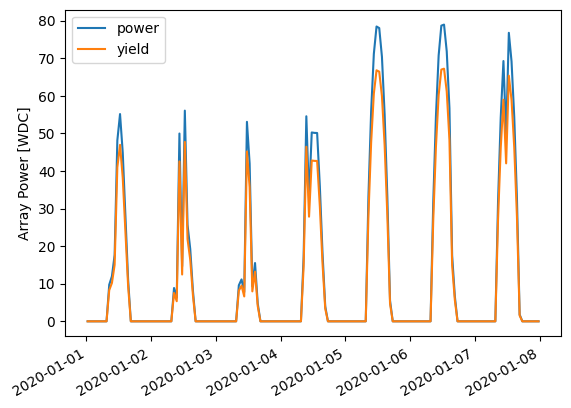

In [757]:
array_power_yield.head(24*7).plot()
plt.ylabel('Array Power [WDC]');

## Economic Modeling & Hardware Costs

Components:

* CAPEX
* Grid electricity value (costs or avoided value)
* PBP
* NPV
* LCOE (LCOSS)

In [758]:
# #average inflation rate for 2024, based on NREL data from https://atb.nrel.gov/electricity/2024/definitions#inflation
# aIR = 0.025

realDiscountRate = 0.022 #2.2% real rate
# nominalDiscountRate = ((1 + realDiscountRate) * (1 + aIR))-1
# print(nominalDiscountRate)
discountRate = realDiscountRate #2% discount rate

# #returns inflation rate after Y years
# #args: year
# def infRate(y, r= aIR):
#     return (1+r)**y

# #argues value to be inflated, year
# def inflateIt(v,y):
#     return v* infRate(y)
    
#args: value to be discounted, year
def discountIt(v, y,r =discountRate):
    return v/(1+r)**y

inflateIt(10,4)

11.038128906249995

### Capital Expenses (CAPEX) i.e. upfront costs

In [759]:
# Upfront Costs

#args: pv watts
def getPVcost(w:int):
    #.7 is based on a 30% tax credit on PV modules
    taxCredit = .3
    #assumes $1 per W modules
    modulePerW = 1.0

    return w * (1-taxCredit) * modulePerW

#this is the total initial expenditure
#args: pv watts, battery price
def getCAPEX(pvW:int,batPr:float,op:float=0.0):
    #total sales tax in NYC is 8.875%
    salesTax =  0.08875 

    if pvW == 0:
        #fixed costs
        insulation = 0 #used for insulating cable entry
        pvCables = 0 #2x 10ft MC4 cables
    else:
        #fixed costs
        insulation = 4.47 #used for insulating cable entry
        pvCables = 17.99 #2x 10ft MC4 cables

    #variable costs
    mountDollarPerW = .4
    smartController = 115.58
    operatingCosts = op #DR aggregation operator costs are not considered here.
    
    fixedHardwareCosts = smartController + operatingCosts + insulation + pvCables

    variableCosts = batPr + getPVcost(pvW) + (pvW * mountDollarPerW)

    return (fixedHardwareCosts + variableCosts) * (1 + salesTax)

#print(getCAPEX(100,200))


### Grid Electricity Costs

In [760]:
# GRID ELECTRICITY COSTS

# https://www.bls.gov/regions/northeast/news-release/averageenergyprices_newyork.htm accessed January 24, 2025
monthlyResElecPricesDollars = [0.265,0.255,0.266,0.259,0.252,0.288,0.288,0.276,0.273,0.274,0.262,0.272]

avgDollarsKw =round(sum(monthlyResElecPricesDollars)/len(monthlyResElecPricesDollars),4) 
print('12 Month NYS Residential Retail Electricity Average: $' + str(avgDollarsKw) + '/kWh')

#args: kWAC generated from PV, year from installation
def utilityCosts(kWAC,y=0):
    
    #utility costs with grid rate NOT increasing with inflation
    annualElectCosts = kWAC * avgDollarsKw #inflateIt(avgDollarsKw,y)
    
    return annualElectCosts

print(utilityCosts(15,3))

12 Month NYS Residential Retail Electricity Average: $0.2692/kWh
4.038


In [798]:
'''
3 grid value scenarios are considered. FIX - All solar shoud be utilized in these scenarios - or include a non-curtainment load requirement???
* battery is only charged from the grid when an event is upcoming. This considers average solar in July
* battery is charged daily from the grid during the 5-month DR season.
* battery is charged daily from the grid during the entire year.
'''

# # negative values means a loss, positive numbers is a gain
# # could be more precise - considering capacity of battery and time of sun in relation to self-consumption
# def getGridValue(pvYieldW, batWh, iE, events=5,y=0):
#     # degrade daily PV yield by year
#     degradedYieldWDC = []
#     for d in pvYieldW:
#         degradedYieldWDC.append(getDegradedP(d,y))

#     # daily energy needs to maintain full charge = self consumption + battery capacity
#     totalDailyWhNeedsDC = dailySelfConsumptionWhDC + (batWh*.8)
#     #print(f'Wh: {totalDailyWhNeedsDC}')

#     # if negative, energy needed from grid
#     # if positive, that energy needs to be consumed by a load
#     dailyEnergyBalanceWhDC = []
#     for b in degradedYieldWDC:
#         dailyEnergyBalanceWhDC.append((b - totalDailyWhNeedsDC))
#     #print(f'Wh:\n {dailyEnergyBalanceWhDC}')
#     annEnergyBalancekWhDC = sum(dailyEnergyBalanceWhDC) * 0.001
    
#     julyStart = drSeasonStartDay + sum(daysInMonth[:2])
#     avgJulyBalanceWh = sum(dailyEnergyBalanceWhDC[julyStart:julyStart+daysInMonth[3]])/daysInMonth[3]
#     avgJulyBalancekWh = avgJulyBalanceWh * 0.001
#     drSeasonEnergyBalancekWh = sum(dailyEnergyBalanceWhDC[drSeasonStartDay:drSeasonStartDay+sum(daysInMonth)]) * 0.001

#     gd = []
#     if avgJulyBalancekWh < 0:
#         gd.append(abs(avgJulyBalancekWh))
#     else: 
#         gd.append(0)
        
#     if drSeasonEnergyBalancekWh < 0:
#         gd.append(abs(drSeasonEnergyBalancekWh))
#     else: 
#         gd.append(0)

#     if drSeasonEnergyBalancekWh < 0:
#         gd.append(abs(annEnergyBalancekWhDC))
#     else: 
#         gd.append(0)

#     def conversionDirection(b):
#         # if the balance is negative and DCWh are being drawn 
#         if b <0:
#             b= b/acToDC # if energy from grid is topping off battery, convert based on grid-charging efficiency ~0.95
#         else:
#             b = b * iE # if energy from PV is replacing grid, convert to AC through inverter. ~0.85
#         return b
        
#     gv={
#         # fix the AC conversion - it is overstating the benefits! if its drawn from the grid, the cost is /.95 if its avoided its *.invEff
#         'avgDailyEnergyBalancekWhDC':annEnergyBalancekWhDC/365, # the d
#         'gridDrawkWhDC': gd, # the amount of energy in the battery from grid
#         'gridValueEvents': utilityCosts(conversionDirection(avgJulyBalancekWh * events),y),# cost of electricity if only drawing from grid to meet load when event is imminent, assumes daily PV is avg for July
#         'gridValueDRSeason':utilityCosts(conversionDirection(drSeasonEnergyBalancekWh),y), # cost of electricity if drawing from grid to maintain battery charge every day during 5-month DR season
#         'gridValueAnnual':utilityCosts(conversionDirection(annEnergyBalancekWhDC),y) # cost of electricity if drawing from grid to maintain battery all year round
#     }
#     #print(gv)
#     return gv

# # run code block below first
# daily_array_power_yield=yieldData[str(180)][str(250)]['daily'] 
# getGridValue(daily_array_power_yield, 1000,.85)

'\n3 grid value scenarios are considered. FIX - All solar shoud be utilized in these scenarios - or include a non-curtainment load requirement???\n* battery is only charged from the grid when an event is upcoming. This considers average solar in July\n* battery is charged daily from the grid during the 5-month DR season.\n* battery is charged daily from the grid during the entire year.\n'

In [835]:
# use this for fixed known loads
def getGridValueHourly(pvYieldW, batWh, loadWAC, iE, events:int=5,y=0,startState:float=1.0):
    loadWDC = loadWAC/iE #convert AC load to DC
    hourlyScWDC = dailySelfConsumptionWhDC / 24 #hourly self-consumption
    
    # step through year hour by hour
    batState = batWh * startState
    avoidedGridWhDC = 0 # convert to AC via inverter
    requiredGridWhDC = 0 # convert to AC via /.95
    degradedYieldWDC = []

    surplusWDC_avgHour = []
    surplusWhDC_totDaily = []
    
    #constrain battery state between 20%-100% capacity
    def constrainBat(s):
        return min(batWh,max(batWh*.2, s))

    dailySurplusWh = []
    for i, h in enumerate(pvYieldW):
        degradedYieldWDC.append(getDegradedP(h,y))

        batState += degradedYieldWDC[-1] - hourlyScWDC #adjust battery status based on PV and SC

        # if all load was addressed
        if (batState-loadWDC) >= (batWh*.2):
            batState -= loadWDC #substract load from battery
            avoidedGridWhDC += loadWDC # add load to avoided grid counter
        elif batState >= batWh*0.2:
            avoidedGridWhDC += (batState - (batWh*.2))
            batState = batWh*.2 #set to state to DoD

        # use grid to ensure battery isn't depleted below 20%
        if batState < batWh*.2:
            requiredGridWhDC += ((batWh*.2)- max(batState,0))
            batState = batWh*.2
        elif batState > batWh:
            dailySurplusWh.append(batState - batWh) #surplus is done on an hourly basis to identify how much PV power can't be stored or used at the time is generated
            
        if (i+1) % 24 == 0:# sum and bucket hours by day
            if sum(dailySurplusWh) > 0:
                surplusWDC_avgHour.append(mean(dailySurplusWh))
                surplusWhDC_totDaily.append(sum(dailySurplusWh))
            dailySurplusWh = []
            
        batState = constrainBat(batState) # limit depleted below DoD

    if len(surplusWhDC_totDaily) == 0:
        surplusWhDC_totDaily = [0]
        surplusWhDC_totDaily_len = 0
        surplusWDC_avgHour = [0]
    else:
        surplusWhDC_totDaily_len = len(surplusWhDC_totDaily)
        #print(mean(surplusWDC_avgHour),min(surplusWDC_avgHour),max(surplusWDC_avgHour))
        
    avg_hourly_surpluskWAC = mean(surplusWDC_avgHour)* 0.001/acToDC 
    max_hourly_surpluskWAC = max(surplusWDC_avgHour)* 0.001/acToDC 
    surpluskWhAC = [s * iE * 0.001 for s in surplusWhDC_totDaily]
    requiredGridkWhAC= (requiredGridWhDC/acToDC) * 0.001
    avoidedGridkWhAC = (avoidedGridWhDC * iE ) * 0.001
    eventGridCharge_kWhAC = (events * batWh * .8 * 0.001) /acToDC #top off from grid for events

    gv = {'daysWithSurplus':surplusWhDC_totDaily_len,
          'avgHourlySurpluskWAC': avg_hourly_surpluskWAC, # average watt surplus (excess power from PV) over the year
          'maxHourlySurpluskWAC': max_hourly_surpluskWAC, # largest watt surplus (excess power from PV) over the year
        'ann_surpluskWhAC':sum(surpluskWhAC),#min(surpluskWhAC),mean(surpluskWhAC),max(surpluskWhAC), ], #the amount of energy that is curtailed and could be conumed - days with a surplus, min, mean, max, total
          'ann_surpluskWhAC_value':utilityCosts(sum(surpluskWhAC)),# potential value if all of surplus is utilized
          'requiredGridkWhAC':requiredGridkWhAC, # require grid draw to maintain the system above DoD
        'requiredGridkWhAC_cost':utilityCosts(requiredGridkWhAC),
          'eventGridChargekWhAC':eventGridCharge_kWhAC,
          'eventGridChargekWhAC_costs':utilityCosts(eventGridCharge_kWhAC),
         'avoidedGridkWhAC':avoidedGridkWhAC, #avoided grid draw by utilizing solar
        'avoidedGridkWhAC_value':utilityCosts(avoidedGridkWhAC)}

    return gv

# run code block below first
hourly_array_power_yield_test=yieldData[str(180)][str(300)]['hourly']['yield']
getGridValueHourly(list(hourly_array_power_yield_test), 1000,100,.85)

{'daysWithSurplus': 0,
 'avgHourlySurpluskWAC': 0.0,
 'maxHourlySurpluskWAC': 0.0,
 'ann_surpluskWhAC': 0.0,
 'ann_surpluskWhAC_value': 0.0,
 'requiredGridkWhAC': 52.80895966878048,
 'requiredGridkWhAC_cost': 14.216171942835706,
 'eventGridChargekWhAC': 4.2105263157894735,
 'eventGridChargekWhAC_costs': 1.1334736842105262,
 'avoidedGridkWhAC': 299.9742808929971,
 'avoidedGridkWhAC_value': 80.75307641639482}

### Payback Period

Payback Period = Initial Investment / Annual Value

In [856]:
#args: capex, grid value, DR revenue
# returns PBP in years
def getPBP(c:float,g:Dict[str,List[float]],dr:list[float])->Dict[str,float]:
    # gK = ['requiredGridkWhAC_cost','eventGridChargekWhAC_costs','avoidedGridkWhAC_value']
    # gKS = ['ann_surpluskWhAC_value']
    
    pbp = {'without_surplus':0,'with_surplus':0}
    avgDr = mean(dr)
    
    gridBalance = mean(g['avoidedGridkWhAC_value']) - mean(g['requiredGridkWhAC_cost']) - mean(g['eventGridChargekWhAC_costs'])
    pbp['without_surplus'] = c/(gridBalance+avgDr)
    pbp['with_surplus'] = c/(gridBalance+avgDr+mean(g['ann_surpluskWhAC_value']))

    return pbp
    
cTest =  300
gTest ={'daysWithSurplus': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'avgHourlySurpluskWAC': 0.0, 'maxHourlySurpluskWAC': 0.0, 'ann_surpluskWhAC': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'ann_surpluskWhAC_value': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'requiredGridkWhAC': [np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895)], 'requiredGridkWhAC_cost': [np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053)], 'eventGridChargekWhAC': [np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632)], 'eventGridChargekWhAC_costs': [np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687)], 'avoidedGridkWhAC': [np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394)], 'avoidedGridkWhAC_value': [np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299)]}
drTest = [np.float64(8.32920429661677), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(3.1849880941306794), 5.6000000000000005, 5.6000000000000005, 5.6000000000000005, 5.6000000000000005, 5.6000000000000005, 5.6000000000000005, 5.6000000000000005, 5.6000000000000005, 5.6000000000000005, np.float64(15.656175588316744), 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0]
getPBP(cTest,gTest,drTest)

{'without_surplus': np.float64(23.885198297952986),
 'with_surplus': np.float64(23.885198297952986)}

### Net Present Value (NPV)

NPV = ∑ (Cash flow / (1 + i)^t) – initial investment

In [859]:
# args: capex, grid value, dr value
def getNPV(c, g, dr):
    npv = {'without_surplus':0,'with_surplus':0}
    wl = min(10, len(dr))
    
    for y in range(wl):
        cashFlow = g['avoidedGridkWhAC_value'][y] - g['requiredGridkWhAC_cost'][y] - g['eventGridChargekWhAC_costs'][y] +dr[y]
        npv['without_surplus'] += (discountIt(cashFlow,wl))
        npv['with_surplus'] += (discountIt(cashFlow+g['ann_surpluskWhAC_value'][y],wl)) 
    return npv

cTest = 799.7739750000002
gTest ={'daysWithSurplus': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'avgHourlySurpluskWAC': 0.0, 'maxHourlySurpluskWAC': 0.0, 'ann_surpluskWhAC': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'ann_surpluskWhAC_value': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)], 'requiredGridkWhAC': [np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895)], 'requiredGridkWhAC_cost': [np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053)], 'eventGridChargekWhAC': [np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632)], 'eventGridChargekWhAC_costs': [np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687)], 'avoidedGridkWhAC': [np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394)], 'avoidedGridkWhAC_value': [np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299)]}
dTest = [np.float64(8.32920429661677), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678), np.float64(14.072826686447678)]
getNPV(cTest,gTest,dTest)


{'without_surplus': np.float64(87.28939910590039),
 'with_surplus': np.float64(87.28939910590039)}

### Levelized Cost of Solar plus Storage (LCOSS)

Total Costs ($)/ Total Energy (kWAC)

In [860]:
#returns the dollar value of the module at the end of the system's working like
# factors in module degradation 
# args: PV watts nameplate,year
def getResidualValue(w,y):
     return getPVcost(getDegradedP(w,y)) #inflateIt(getPVcost(getDegradedP(w,y)),y)
 
#test
#getResidualValue(100, 8.3)

In [869]:
'''
LEVELIZED COST OF SOLAR plus STORAGE
Numerator = CAPEX + O&M (Cost of purchased electricity) - RESIDUAL VALUE
Denomenator = PV WhAC Yield + ELEC FROM GRID TO BATTERY AND BACK (Note self consumption included in PV WhAC)

Everything gets discounted and not inflated!
'''

# capex, gridValue, pv watts, solarYield kWh, effective efficiency
def getLCOSS(c, g, w, sYkW, eE):
    # calculate residual solar panel value (includes inflation)
    resVal =  getResidualValue(w,min(len(d),10))
 
    wl = len(g['avoidedGridkWhAC_value']) #working life

     #g['avoidedGridkWhAC_value'][y] - g['requiredGridkWhAC_cost'][y] - g['eventGridChargekWhAC_costs'][y] +dr[y]
    #ann_surpluskWhAC_value

    
    lcoss = {'without_surplus':0,'with_surplus':0}       
   
    num = c - discountIt(resVal,wl-1)
    den = 0
    for y in range(wl):
        num += discountIt(g['requiredGridkWhAC_cost'][y] + g['eventGridChargekWhAC_costs'][y],y)
        
        #PV to bat to load
        stbtl = discountIt(g['avoidedGridkWhAC'][y]* eE,y)
        #Grid to battery to load
        gtbtl = discountIt((g['requiredGridkWhAC'][y]+g['eventGridChargekWhAC'][y])*.95*eE,y)
        den += stbtl + gtbtl  #total solar production + total from grid

    lcoss['without_surplus']=num/den

    num = c - discountIt(resVal,wl-1)
    den = 0
    for y in range(wl):
        num += discountIt(g['requiredGridkWhAC_cost'][y] + g['eventGridChargekWhAC_costs'][y],y)
        
        #PV to bat to load
        stbtl = discountIt(g['avoidedGridkWhAC'][y],y)
        #Grid to battery to load
        gtbtl = discountIt((g['requiredGridkWhAC'][y]+g['eventGridChargekWhAC'][y])*.95*eE,y) + discountIt(g['ann_surpluskWhAC'][y],y)
        den += stbtl + gtbtl  #total solar production + total from grid

    lcoss['with_surplus']=num/den

    return lcoss

cTest = 799.7739750000002
gTest ={'daysWithSurplus': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'avgHourlySurpluskWAC': 0.0, 'maxHourlySurpluskWAC': 0.0,
        'ann_surpluskWhAC': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)],
        'ann_surpluskWhAC_value': [np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)],
        'requiredGridkWhAC': [np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895), np.float64(4.382105263157895)],
        'requiredGridkWhAC_cost': [np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053), np.float64(1.1796627368421053)],
        'eventGridChargekWhAC': [np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632), np.float64(6.467368421052632)],
        'eventGridChargekWhAC_costs': [np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687), np.float64(1.7410155789473687)],
        'avoidedGridkWhAC': [np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394), np.float64(1.0149751746234394)],
        'avoidedGridkWhAC_value': [np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299), np.float64(0.2732313170086299)]}
wTest =0
sYkWTest = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
eETest = 0.849849430313522
 
getLCOSS(cTest,gTest,wTest,sYTest,eETest) 

{'without_surplus': np.float64(9.45276272877714),
 'with_surplus': np.float64(9.305378083070657)}

## Automated DR Participation

In [725]:
# returns the max value for a given load - does not consider the ability to meet the load needs
def drValue(loadW, cRate, dRate, prefix='', m=5):
    annValResProgram_csrp = loadW * .001 * cRate * m #CSRP reservation value for full coverage of load
    annValResProgram_dlrp = loadW * .001 * dRate * m #DLRP reservation value for full coverage of load
    annValResTot = annValResProgram_csrp + annValResProgram_dlrp # Total DR reservation value for full coverage
    annValPer_csrp = loadW * .001 * csrpEvents #CSRP performance value for full coverage of load
    annValPer_dlrp = loadW * .001 * dlrpEvents #DLRP performance value for full coverage of load
    annValPer = annValPer_csrp + annValPer_dlrp #total performance value for full coverage of load
    annTotVal = annValResTot + annValPer # total value for full coverage of load

    drv = {
        f"{prefix}annValResProgram_csrp" : annValResProgram_csrp,
        f"{prefix}annValResProgram_dlrp" : annValResProgram_dlrp,
        f"{prefix}annValResTot" : annValResTot,
        f"{prefix}annValPer_csrp" : annValPer_csrp,
        f"{prefix}annValPer_dlrp" : annValPer_dlrp,
        f"{prefix}annValPer" : annValPer,
        f"{prefix}annTotVal" : annTotVal
    }
    return drv

# returns percentage of the load that can be addressed and the dollar value
def drFlexValue(csrpkWACtotal_y, loadkW, rate, eventNum, replacement_kW=0, prefix=''):
    res = {}
    cPerc = csrpkWACtotal_y/loadkW # percentage of load covered
    cFlexedkW = min(csrpkWACtotal_y,loadkW) #kWAC flexed up to baseline
    res['cPerc']=cPerc
    if replacement_kW ==0:
        resInc = cFlexedkW * rate # monthly reservation income
        perfInc = cFlexedkW * 4 * eventNum # monthly performance income
    else:
        replaced = replacement_kW * min(1,cPerc)  # the replacement is scaled based on the percentage of the event the replacement load can run for
        resInc = replaced * rate # monthly reservation income
        perfInc = replaced * 4 * eventNum # monthly performance income
    res['inc'] = resInc + perfInc
    return res

### CSRP

In [726]:
#Max automated battery + PV generation during event windows from May through September
#assumes battery is fully charged (from either PV or grid) at start of event
#returns average hourly commitment i.e. reservation amount in watts AC
# i.e. it returns what can automatically be provided per hour for 4 hours during a event in a given month

#get the available hourly watts if the battery is fully depleted over 4 hours
#arg: battery WhDC
def getFourHourW(bWh:float):
    return bWh * LiFePOdod * .25

# #returns a list with the average maximum automated participation for each of the 5 months
# #args: battery Wh, hourly PV W yield, inverter efficiency, start time, inverter max watts, self-consumption=0, year=0
# def performanceCSRP(batWh, pvWyield,iE,sT,iM,sC = 0, year=0):
#     #divide available Wh by 4 to account for the 4-hour long event window
#     #this assumes a full battery at the onset of the event
#     #subtract self-consumption
#     batteryACOutput = getACoutput(getFourHourW(batWh)-sC,iM,iE)

#     runningTot = 0

#     #days in the months May - September
#     daysInMonth = [31,30,31,31,30]
    
#     #returns average WAC generated for all window hours on a monthly basis
#     #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
#     elapsedDays = 121
#     drEventWhAC_MonthlyAvg = []
#     #loop through the months
#     for m in range(len(daysInMonth)):
#         #print(daysInMonth[m])
#         drEventWhAC_DailyAvg = 0
#         #loop through days in the month
#         for d in range(elapsedDays, elapsedDays +  daysInMonth[m]):
#             #print(d)
#             drEventWhAC = 0
#             #loop through the 4 hours during the event
#             for e in range(sT,sT + 4):
#                 #PV Yield for 1 hour during the event window
#                 drHour = ((d-1)*24)+e
#                 #print(getACoutput(pvWyield[drHour],iM,iE))
#                 drEventWhAC += getACoutput(getDegradedP(pvWyield[drHour],year),iM,iE)
#             #print(drEventWhAC)
#             #get the average for the day
#             drEventWhAC_DailyAvg += drEventWhAC * .25
#         #print((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
#         drEventWhAC_MonthlyAvg.append((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
#         drEventWhAC_DailyAvg = 0
#         elapsedDays += daysInMonth[m]
    
#         #this is averaged to an hourly basis NOT the total production during the event
#         #runningTot = runningTot + (drEventDCWh/4)
    
#     numDays = 274-121
#     #print(drEventWhAC_MonthlyAvg)
#     return drEventWhAC_MonthlyAvg

# #uncomment to test
# performanceCSRP(2000, array_power_yield['yield'], invEffDefault,11,500,5)

In [727]:

#returns a list with the average maximum automated participation for each of the 5 months
#args: hourly PV W yield, inverter efficiency, start time, inverter max watts, year=0
def solarEventYieldkWAC(pvWyield,iE,sT,iM, year=0)-> list:
    runningTot = 0
    
    #returns average WAC generated for all window hours on a monthly basis
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    elapsedDays = 121
    drEventWhAC_MonthlyAvg = []
    #loop through the months
    for m in range(len(daysInMonth)):
        #print(daysInMonth[m])
        drEventWhAC_DailyAvg = 0
        #loop through days in the month
        for d in range(elapsedDays, elapsedDays +  daysInMonth[m]):
            #print(d)
            drEventWhAC = 0
            #loop through the 4 hours during the event
            for e in range(sT,sT + 4):
                #PV Yield for 1 hour during the event window
                drHour = ((d-1)*24)+e
                #print(getACoutput(pvWyield[drHour],iM,iE))
                drEventWhAC += getACoutput(getDegradedP(pvWyield[drHour],year),iM,iE)* 0.001
            #print(drEventWhAC)
            #get the average for the day
            drEventWhAC_DailyAvg += drEventWhAC * .25
        #print((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        drEventWhAC_MonthlyAvg.append(drEventWhAC_DailyAvg/daysInMonth[m])
        drEventWhAC_DailyAvg = 0
        elapsedDays += daysInMonth[m]
    
        #this is averaged to an hourly basis NOT the total production during the event
        #runningTot = runningTot + (drEventDCWh/4)
    
    numDays = 274-121
    #print(drEventWhAC_MonthlyAvg)
    return drEventWhAC_MonthlyAvg

#returns a list with the average daily PV prior to the start of a DR event
#args: hourly PV W yield, start time, year=0
def solarPriorEventYieldWDC(pvWyield,sT, year=0)-> list:
    runningTot = 0

    #days in the months May - September
    daysInMonth = [31,30,31,31,30]
    
    #returns average WAC generated for all window hours on a monthly basis
    #Get all the DR event window hours from May 1st (day #121) through September 30th (day # 273)
    elapsedDays = drSeasonStartDay
    monthlyAvg = []
    #loop through the months
    for m in range(len(daysInMonth)):
        #print(daysInMonth[m])
        dailyAvg = 0
        #loop through days in the month
        for d in range(elapsedDays, elapsedDays +  daysInMonth[m]):
            #print(d)
            WhDC = 0
            #loop through all the hours prior to the event
            for e in range(0,sT):
                #PV Yield for 1 hour prior to the event window
                h = ((d-1)*24)+e
                WhDC += getDegradedP(pvWyield[h],year)
            #get the average for the day
            dailyAvg += WhDC
        #print((drEventWhAC_DailyAvg/daysInMonth[m]) + batteryACOutput)
        monthlyAvg.append(dailyAvg/daysInMonth[m])
        dailyAvg = 0
        elapsedDays += daysInMonth[m]
    
    numDays = 274-121
    return monthlyAvg

### DLRP

In [728]:
#morning yeild for DLRP events
#this used for determining starting battery capacity, so should be returned DC with mppt losses
#returns average PV Wh yield DC that can be stored in the battery prior to a given time of the day in July
#use 2pm for contingency event starts and 10am for immediate event starts
#args PV yield, event type, year for PV degradation
def morningYield(pvWyield, event='c',year=0):
    #contingency event
    t = 18
    if event == 'i':
        #immediate event
        t = 14

    #loop through 31 days in July
    days = 31
    startDay = 182
    dailyAvg = 0
    for d in range(startDay, startDay + days):
        #loop through hours in the day
        dailyPV = 0
        for e in range(0,t):
            #PV Yield for 1 hour during the event window
            myHour = ((d-1)*24)+e
            #print(getACoutput(pvWyield[drHour],iM,iE))
            dailyPV += getDegradedP(pvWyield[myHour],year)*.99
        dailyAvg += dailyPV
    
    return dailyAvg / days

morningYield(array_power_yield['yield'],'i')

C:\Users\alexn\AppData\Local\Temp\ipykernel_6904\3115399611.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dailyPV += getDegradedP(pvWyield[myHour],year)*.99


np.float64(342.06729278539643)

In [729]:
#returns the DC Wh the battery charged up to in 2 hours of charging from the grid
#does not include the bottom 20%
#arga: battery capacity, full grid charge time, top 20% charge time
def twoHourChargeWh(batWh,gridPT, gridT):
    maxB = batWh * .8
    #time it takes to charge from 20% to 80% percent
    e = gridPT - gridT #* eightyCT * .75
    #print(e)
    #time it takes o
    t = gridPT
    #print(t)
    #print(e+t)
    #if 80% is reached in under 2 hours
    if e < 2:
        #print('80 under 2')
        #remaining hours
        return min(maxB,(batWh * .2 * ((2-e)/t)) + (batWh * .6))
    else:
        #print('80 not under 2')
        #if 20%-80% isn't reached in 2 hours
        #prorate that chunk 
        return batWh * .6 * (2/e)
    
    #chargeAmt = min(1,2/(gridT*.8))

#returns a list with the maximum automated participation for each of the 5 months
#args: battery Wh, grid charge hours 20-100%, grid charge time 80-100%, hourly PV W yield, inverter efficiency, inverter max watts, self-consumption=0, year=0, event
# def performanceDLRP(batWh, gridPT, gridT, pvWyield,iE,iM,sC = 0, year=0,event='c'):
    
#     maxWh = getFourHourW(batWh)
    
#     #get the available PV yield from the morning spread out over 4 hours of event time
#     mY = morningYield(pvWyield, event,year)*.25
    
#     #this assumes battery wasn't depleted below 20%
#     if event == 'c':
#         #DLRP assumes charged as much as possible in 2 hours. It doesn't assume a full battery.
        
#         #if grid charge time from 20%-100% > 2 hours
#         if gridPT > 2:
#             availableWh = twoHourChargeWh(batWh,gridPT, gridT) * 0.25
#         else:
#             availableWh = getFourHourW(batWh)        
        
#         availableWh = min(maxWh, availableWh + mY)
#     else:
#         #for immediate events with no time to charge the battery from the grid,
#         #the available energy is based off of PV production from earlier in the day
#         availableWh = min(maxWh, mY)
        
#     #subtract self-consumption and account for inverter losses
#     batteryACOutput = getACoutput(availableWh-sC,iM,iE)

#     drEventWhAC_MonthlyAvg = []
#     for m in range(5):
#           drEventWhAC_MonthlyAvg.append(batteryACOutput)

#     return drEventWhAC_MonthlyAvg

# performanceDLRP(3000, 2.2, 1.6, array_power_yield['yield'], invEffDefault,500,5,10,'c')

In [730]:
# returns the annual income produced by DR performance, which is $1/kWh
#args: energy in Wh, average annual events
#returns dollar amount
def getPerformanceAmount(e, aaE=3):
    return e * 0.001 * aaE * 4

## Main Loop

This loop generates all the possible combinations of hardware and their energy and economic characteristics based on the constraints of the battery. 

In [731]:
#these networks are selected because they represent all possible combinations of characteristics

#myNetworks2023 = ['city hall','long island city','crown heights','randalls island', 'millwood west', 'grasslands','fresh kills','central bronx','northeast bronx']

In [732]:
#get hourly PV yields for all possible arrays being modeled at all azimuths
yieldData = {
    '110':{},
    '180':{},
    '250':{}
}

# max allowed PV of any power station in the database
maxPV = max(hardware_df['Max PV Watts'])
print(f'Max PV: {maxPV}')

for a in [110, 180, 250]:
    poa = getPOA(tilt, a)
    
    aData = {}
    for pW in range(10,maxPV+10,10):
        #get hourly power yields for a given array size (W)
        hY = getPowerYield(poa,gamma_pdc, pW)
        
        #get daily PV yields (Wh)
        dY = []
        for d in range(365):
            #print(hY['yield'].iloc[d*24:(d*24)+24].sum())
            dY.append(hY['yield'].iloc[d*24:(d*24)+24].sum())
        aData[str(pW)] = {'hourly':hY,'daily':dY}
        
    yieldData[str(a)]= aData

#print(yieldData['180']['40'])

Max PV: 2400


In [898]:
# true = quick test, false = full run
testMode = False
testModeNetworks = False
testModeBatteries = testMode
testModeAzimuth = True
testModePV = testMode
testModeF = True

# print('test mode: ' + str(testMode))

# print('loop start time:')
# print(datetime.now())

# network max DR values ($) by load scenario
nData = {
        'network':[],
        'load1W':[],
        'load2W':[],
        'load1RW':[],
        'l1_annValResProgram_csrp' : [],
        'l1_annValResProgram_dlrp' : [],
        'l1_annValResTot':[],
        'l1_annValPer_csrp' : [],
        'l1_annValPer_dlrp' : [],
        'l1_annValPer' : [],
        'l1_annTotVal' : [],
        'l2_annValResProgram_csrp' : [],
        'l2_annValResProgram_dlrp' : [],
        'l2_annValResTot':[],
        'l2_annValPer_csrp' : [],
        'l2_annValPer_dlrp' : [],
        'l2_annValPer' : [],
        'l2_annTotVal' : []
        }

rData = {
        'network':[],
        'eventStart':[],
        'dlrp_rate':[],
        'csrp_rate':[],
        'az':[],
        'pvW':[],
        'batModel':[],
        'batWh':[],
        'batWhAC':[],
        'effEff':[],#effective real efficiency
        'dischargeRateW':[],
        'capex':[],

        'cycles':[],
        'lifespan':[],
        'workingLife':[],
        'dailyPVWhAC_4M':[], #year 1 PV yields AC: min, max, mean, median
        'annualPVkWhDC_degraded':[],
        'annualPVkWhAC_degraded':[],
        'immediateEventAmt':[],
        # 'avgAutoParticipationMonthlyW_C':[],
        # 'avgAutoParticipationMonthlyW_D':[],
        # 'avgAutoParticipationAnnualW_C':[],
        # 'avgAutoParticipationAnnualW_D':[],
        # 'avgMAPw_C':[], #averaged annual auto participation W
        # 'avgMAPw_D':[], #averaged max auto participation W
        # 'totalDRratekW':[],
    
        # 'drIncMonthly_C':[],
        # 'drIncMonthly_D':[],
        # 'drIncAnnual_C':[],
        # 'drIncAnnual_D':[],
        # 'drPerformanceIncome':[],

        'csrpMaxFlex':[],
        'csrpLoad1_percentage':[],
        'csrpLoad2_percentage':[],
        'csrpLoad1replacement_percentage':[],
        'csrpLoad1Income':[],
        'csrpLoad2Income':[],
        'csrpLoad1RIncome':[],

        'dlrpMaxFlex':[],
        'dlrpLoad1_percentage':[],
        'dlrpLoad2_percentage':[],
        'dlrpLoad1replacement_percentage':[],
        'dlrpLoad1Income':[],
        'dlrpLoad2Income':[],
        'dlrpLoad1RIncome':[],

        'annDRIncomeLoad1': [],
        'annDRIncomeLoad2': [],
        'annDRIncomeLoad1R': [],

        'gridValue_load1':[],
        'gridValue_load2':[],
        'gridValue_load1R':[],
        
        'load1_NPV':[],
        'load2_NPV':[],
        'load1R_NPV':[],
    
        'load1_PBP':[], #real rate of return includes inflation and PV degradation (does not include discount rate)
        'load2_PBP':[],
        'load1R_PBP':[],

        'load1_LCOSS':[],
        'load2_LCOSS':[],
        'load1R_LCOSS':[]
    }

In [908]:
'''
keys questions
PV usage all year round -> avoided grid costs?
battery % gaurantees
impact of controls (does this need a test?)
'''
print(f'Test mode: {testMode}')
st = datetime.now()
print(f'loop start time:{st}')
print('')

# reset rData just in case
for k,v in rData.items():
    rData[k] = []

csrpEvents = 4 # number of CSRP events annually
dlrpEvents = 1 # number of DLRP events annually
months = 5 # number of months DR programs run
programs = 2 # number of programs

years = 10 # max years

# also run it for max load
# loadOneW = 500 # AC
# loadTwoW = 100 # fridge
# loadOneW_Replacement = 80 # Fan

loads = {'loadOneW':500, # AC
        'loadTwoW':100, # fridge
        'loadOneW_Replacement':75} # fan


######################
##### TEST SETUP #####
######################
loopCount = []
loopNumber = 0

if testModeNetworks:
    myNetworks = ['bowling green']
else:
    #these networks are selected because they represent all possible combinations of characteristics
    myNetworks = ['bowling green','long island city','sunnyside','crown heights','grasslands','fresh kills','williamsburg','northeast bronx','ridgewood']

#loop through all networks
loopCount.append(len(myNetworks))

if testModeBatteries:
    bRange = range(10,12) #
else:  
    bRange = range(hardware_df.shape[0])
loopCount.append(len(bRange))

if testModePV:
    pRange = [0,100]#range(0,30,10)
else:
    #loop through all allowed PV modules sizes, incrementing by 20W
    pRange = range(0,min(pvMaxW,maxPV) +20,20)
loopCount.append(len(pRange))

if testModeAzimuth: #) or (pW == 0):
    aRange = [180]
else:
    #loop through 3 azimuths
    aRange = [110,180,250]
loopCount.append(len(aRange))

if testModeF:
    fRange = [0]
else:
    fRange = [0,1,5]
loopCount.append(len(fRange))
    
# calculate loop count
loopCountInt = 1
for l in loopCount:
    loopCountInt = loopCountInt * l
####################
##### RUN TEST #####
####################
for n in myNetworks:
    
    print(n)
    startTime = getStartTime(n)
    dlrpStart = 10 # assumes a 10am start - needed for estimating PV contribution
    
    #monthly income from DR participation
    #the DR rate for each program
    dlrp_rate= getDLRPrate(n)
    csrp_rate = getCSRPrate(n)
        
    loadOneDR = drValue(loads['loadOneW'],csrp_rate,dlrp_rate,"l1_")
    #print(loadOneDR)
        
    loadTwoDR = drValue(loads['loadTwoW'],csrp_rate,dlrp_rate,"l2_")
    #print(loadTwoDR)

    ###### package network data (hardware agnostic) #########
    nData['network'].append(n)
    nData['load1W'].append(loads['loadOneW'])
    nData['load2W'].append(loads['loadTwoW'])
    nData['load1RW'].append(loads['loadOneW_Replacement'])
    #merged = {**dict2, **dict1}
    # nData['load1MaxDRInc'].append(loadOneDR)
    # nData['load2MaxDRInc'].append(loadTwoDR)

    # Unpack loadTwoDR into nData
    for k, v in loadOneDR.items():
        nData[k].append(v)
    # Unpack loadTwoDR into nData
    for k, v in loadTwoDR.items():
        nData[k].append(v)

    #loop through all batteries in database
    for b in bRange:

        #print('')
        #get battery info
        d = hardware_df.iloc[b]
        #print(d)
    
        bWh = d['Battery Wh']
        bModel = d['Model']
        
        #time in hours it takes to charge the battery
        #from 0% to 100% from the grid
        bCT = d['Full Grid Charge Hours']
        #from 80% to 100% from grid
        bFCT = d['Full Grid Charge Hours']-d['80 Per Grid Charge Hours']
        #the charge time from 20% to 100%
        practicalBCT = (d['80 Per Grid Charge Hours'] * .75) + bFCT #this is what we care about for DR
        #print(f'20-100% Charge Time: {round(practicalBCT,3)} hours')

        #convert to AC
        #battery is depleted 80% at 4-hour rate
        fH = getFourHourW(bWh) # WDC
        
        #effective efficiency is the actualy efficiency when consuming power at the 4 hour rate
        effectiveEfficiency = getACoutput(fH,d['Inverter Watts'],invEffDefault)/fH
    
        #bat capacity down to DoD
        realBWh = bWh * LiFePOdod
        
        #bat WhAC capacity
        bWhAC = realBWh * effectiveEfficiency
        #print(f'Battery Capacity: {round(bWhAC,3)} WhAC')

        loadMaxBatDR = drValue(bWhAC/4,csrp_rate,dlrp_rate) # not doing anthing with this yet
        #print(loadMaxBatDR)

        #life span assumes 1 full cycle a day
        lS = d['Cycles']/365
        #working life caps the lifespan at 10 years
        wL = min(10,lS)
        wLrounded = math.ceil(wL) # round wL up for some calculations
        
        for pW in pRange:

            #if the array exceeds the power station capacity, skip it
            if pW > d['Max PV Watts']:
                continue

            #Hardware Costs in Dollars
            capex =getCAPEX(pW,d['retail price'])
    
            for a in aRange:

                ################
                ###### PV ######
                ################
                
                csrpPV_kWAC = [] # avg PV production during event, by month 
                dlrpPV_kWAC = [] # pv production average for July
                #priorCSRP_WDC = [] #not required
                priorDRLP_WDC = []
                
                if pW != 0:
                    #get hourly power yields for a given array size
                    hourly_array_power_yield=yieldData[str(a)][str(pW)]['hourly']['yield']
                    for y in range(wLrounded):
                        # these are the solar yields during events - double check!
                        monthlyYields = solarEventYieldkWAC(hourly_array_power_yield,invEffDefault,getStartTime(n),d['Inverter Watts'], y)
                        csrpPV_kWAC.append([monthlyYields[2],monthlyYields[2],monthlyYields[2],monthlyYields[3],monthlyYields[3]]) #based on event history, performance is typically based on events in July and August
                        dlrpPV_kWAC.append(solarEventYieldkWAC(hourly_array_power_yield,invEffDefault,dlrpStart,d['Inverter Watts'], y)[2]) #dlrp starts at 10am

                        #priorCSRP_WDC.append(solarPriorEventYieldWDC(array_power_yield['yield'],getStartTime(n),y))
                        priorDRLP_WDC.append(solarPriorEventYieldWDC(hourly_array_power_yield,dlrpStart,y)[2]) #compare this with the older morningYield function

                    daily_array_power_yield=yieldData[str(a)][str(pW)]['daily'] 
                    
                else: # fill it with zeros
                    for y in range(wLrounded):
                        csrpPV_kWAC.append([0,0,0,0,0])
                        dlrpPV_kWAC.append(0)
                        priorDRLP_WDC.append(0)

                    daily_array_power_yield = [0] * 365
                
                minDailyYieldWhAC = (min(daily_array_power_yield) - dailySelfConsumptionWhDC)* effectiveEfficiency
                maxDailyYieldWhAC = (max(daily_array_power_yield) - dailySelfConsumptionWhDC)* effectiveEfficiency
                meanDailyYieldWhAC = (mean(daily_array_power_yield) - dailySelfConsumptionWhDC)* effectiveEfficiency
                medianDailyYieldWhAC = (median(daily_array_power_yield) - dailySelfConsumptionWhDC)* effectiveEfficiency
                
                #year 1 PV daily yields: min, max, mean, median
                #this is what needs to be consumed to avoid curtailment
                pvDailyWhAC_4M = [minDailyYieldWhAC,maxDailyYieldWhAC,meanDailyYieldWhAC,medianDailyYieldWhAC]
                
                annualPVkWhDC_degraded = []
                annualPVkWhAC_degraded = []
                for y in range(wLrounded):
                    annualPVkWhDC_degraded.append(getDegradedP(sum(daily_array_power_yield),y)*0.001)
                    annualPVkWhAC_degraded.append(annualPVkWhDC_degraded[-1] * 0.001 * effectiveEfficiency)
                
                ################
                ##### Grid #####
                ################

                # creates a list by load scenarios
                gridValue = {}
               
                for k,l in loads.items(): 
                    gVL = {}
                    for y in range(wLrounded):
                        if d['Inverter Watts'] < l: #if the inverter can't support the load
                            l = 0
                        # grid value includes inflation
                        for kr, v in getGridValueHourly(list(hourly_array_power_yield), bWh,l,effectiveEfficiency,csrpEvents+dlrpEvents,y).items():
                            if kr in gVL.keys():
                                gVL[kr].append(v)
                            else:
                                gVL[kr] = [v]
                    gVL['avgHourlySurpluskWAC']=mean(gVL['avgHourlySurpluskWAC'])
                    gVL['maxHourlySurpluskWAC']=mean(gVL['maxHourlySurpluskWAC'])
                    
                    gridValue[k]=gVL

                #print(gridValue)

                ################
                ##### CSRP #####
                ################
                loadOne_kW = loads['loadOneW']*.001
                loadTwo_kW = loads['loadTwoW']*.001
                loadOneReplacement_kW = loads['loadOneW_Replacement']*.001
                
                # csrp charge time : adjust battery capacity based on charge time
                # can battery be fully charged in less than 21 hours?
                if practicalBCT <= 21:
                    FbWh = realBWh 
                else: 
                    FbWh = min(realBWh,realBWh * (21/practicalBCT))
        
                csrpkWAC_total = [] # max flexibility (avg of all months)
                csrpLoad1_percentage = [] # percentage of baseline load directly addressible through CSRP
                csrpLoad2_percentage = [] # percentage of baseline load directly addressible through CSRP
                csrpLoad1replacement_percentage = [] # percentage of baseline load directly addressible through CSRP (with curtailing L1)
                csrpLoad1_Income = []
                csrpLoad2_Income = []
                csrpLoad1replacement_Income = []

                for y in range(wLrounded):
                    # csrp has a 21-hour notice, so always fully charged
                    csrpkWAC_atStart = (((FbWh/4)-scWDC)*effectiveEfficiency * .001)#csrp capacity at start of event
                    csrpkWAC_total.append(csrpkWAC_atStart + mean(csrpPV_kWAC[y])) #taking the avg of all months works here, because specific months were selected above

                    # load 1
                    fVresults = drFlexValue(csrpkWAC_total[y], loadOne_kW, csrp_rate, csrpEvents)
                    csrpLoad1_percentage.append(fVresults['cPerc'])
                    csrpLoad1_Income.append(fVresults['inc'])

                    # load 2
                    fVresults = drFlexValue(csrpkWAC_total[y], loadTwo_kW, csrp_rate, csrpEvents)
                    csrpLoad2_percentage.append(fVresults['cPerc'])
                    csrpLoad2_Income.append(fVresults['inc'])

                    # load 1 Replacement
                    fVresults = drFlexValue(csrpkWAC_total[y], loadOneReplacement_kW, csrp_rate, csrpEvents,loadOne_kW)
                    csrpLoad1replacement_percentage.append(fVresults['cPerc'])
                    csrpLoad1replacement_Income.append(fVresults['inc'])

                ################
                ##### DLRP #####
                ################
                
                #immediate event frequency
                for i in fRange:
                    loopNumber += 1
                    if loopNumber % 100 == 0:
                        if loopNumber >1:
                            et = datetime.now() - st
                            tr = round(((et.seconds/loopNumber) * (loopCountInt - loopNumber)) / 60,2)
                        else:
                            tr = 'unknown'
                        print(f'{loopNumber} of {loopCountInt} : {tr} minutes estimated remaining')

                    dlrpkWAC_total = [] # max flexibility (avg of all months)
                    dlrpLoad1_percentage = [] # percentage of baseline load directly addressible through CSRP
                    dlrpLoad2_percentage = [] # percentage of baseline load directly addressible through CSRP
                    dlrpLoad1replacement_percentage = [] # percentage of baseline load directly addressible through CSRP (with curtailing L1)
                    dlrpLoad1_Income = []
                    dlrpLoad2_Income = []
                    dlrpLoad1replacement_Income = []

                    for y in range(wLrounded):
                        #determine if its a contingency year or an emergency year
                        if i == 0: 
                            eventType = 'c'
                        else:
                            if y < i:
                                eventType ='i'
                            else:
                                eventType ='c'
                        
                        if eventType == 'c':
                            #dlrp charge time - adjust battery capacity based on charge time
                            if practicalBCT <= 2:
                                FbWh = realBWh 
                            else: 
                                FbWh = min((realBWh * (2/practicalBCT)) + priorDRLP_WDC[y],realBWh)
                        elif eventType == 'i':
                            # this can be changed based on controls!
                            FbWh = min(priorDRLP_WDC[y],realBWh)

                        dlrpkWAC_atStart = (((FbWh/4)-scWDC)*effectiveEfficiency * .001) #battery capacity at start of event
                        dlrpkWAC_total.append(dlrpkWAC_atStart + dlrpPV_kWAC[y])
                        
                        # load 1
                        fVresults = drFlexValue(dlrpkWAC_total[y], loadOne_kW, dlrp_rate, dlrpEvents)
                        dlrpLoad1_percentage.append(fVresults['cPerc'])
                        dlrpLoad1_Income.append(fVresults['inc'])
                        
                        # load 2
                        #cPerc = dlrpkWAC_total[y]/loadTwo_kW
                        fVresults = drFlexValue(dlrpkWAC_total[y], loadTwo_kW, dlrp_rate, dlrpEvents)
                        dlrpLoad2_percentage.append(fVresults['cPerc'])
                        dlrpLoad2_Income.append(fVresults['inc'])
    
                        # load 1 Replacement
                        fVresults = drFlexValue(dlrpkWAC_total[y], loadOneReplacement_kW, dlrp_rate, dlrpEvents,loadOne_kW)
                        dlrpLoad1replacement_percentage.append(fVresults['cPerc'])
                        dlrpLoad1replacement_Income.append(fVresults['inc'])
  
                    ##########################
                    ##### Packaging Data #####
                    ##########################

                    rData['network'].append(n)
                    rData['eventStart'].append(getStartTime(n))
                    rData['dlrp_rate'].append(dlrp_rate)
                    rData['csrp_rate'].append(csrp_rate)

                    # also run it for max load

                    rData['az'].append(a)
                    #PV Watts
                    rData['pvW'].append(pW)
                    
                    rData['dailyPVWhAC_4M'].append(pvDailyWhAC_4M) #year 1 PV yields AC: min, max, mean, median
                    rData['annualPVkWhDC_degraded'].append(annualPVkWhDC_degraded)
                    rData['annualPVkWhAC_degraded'].append(annualPVkWhAC_degraded)
                    
                    #battery model name
                    rData['batModel'].append(bModel)
                    #Battery Watt Hours
                    rData['batWh'].append(bWh)
                    rData['batWhAC'].append(bWhAC)
                    rData['effEff'].append(effectiveEfficiency)
                    rData['dischargeRateW'].append(fH)
                    rData['capex'].append(capex)
                    #rData['dollarPerBatkWh'].append((capex/bWh)*.001)#this is to compare against NREL data in the discussion section

                    rData['cycles'].append(d['Cycles'])
                    rData['lifespan'].append(lS)
                    rData['workingLife'].append(wL)
                    
                    rData['immediateEventAmt'].append(i) #values are 0, 1, or 5

                    rData['csrpMaxFlex'].append(csrpkWAC_total)
                    rData['csrpLoad1_percentage'].append(csrpLoad1_percentage) # percentage of baseline load directly addressible through CSRP
                    rData['csrpLoad2_percentage'].append(csrpLoad2_percentage) # percentage of baseline load directly addressible through CSRP
                    rData['csrpLoad1replacement_percentage'].append(csrpLoad1replacement_percentage) # percentage of baseline load directly addressible through CSRP (with curtailing L1)
                    rData['csrpLoad1Income'].append(csrpLoad1_Income)
                    rData['csrpLoad2Income'].append(csrpLoad2_Income)
                    rData['csrpLoad1RIncome'].append(csrpLoad1replacement_Income)

                    rData['dlrpMaxFlex'].append(dlrpkWAC_total)
                    rData['dlrpLoad1_percentage'].append(dlrpLoad1_percentage) # percentage of baseline load directly addressible through CSRP
                    rData['dlrpLoad2_percentage'].append(dlrpLoad2_percentage) # percentage of baseline load directly addressible through CSRP
                    rData['dlrpLoad1replacement_percentage'].append(dlrpLoad1replacement_percentage) # percentage of baseline load directly addressible through CSRP (with curtailing L1)
                    rData['dlrpLoad1Income'].append(dlrpLoad1_Income)
                    rData['dlrpLoad2Income'].append(dlrpLoad2_Income)
                    rData['dlrpLoad1RIncome'].append(dlrpLoad1replacement_Income)

                    annTotDRIncL1 = []
                    for y in range(len(csrpLoad1_Income)):
                        annTotDRIncL1.append(csrpLoad1_Income[y] + dlrpLoad1_Income[y])
                        
                    annTotDRIncL2 = []
                    for y in range(len(csrpLoad2_Income)):
                        annTotDRIncL2.append(csrpLoad2_Income[y] + dlrpLoad2_Income[y])
                        
                    annTotDRIncL1R = []
                    for y in range(len(csrpLoad1replacement_Income)):
                        annTotDRIncL1R.append(csrpLoad1replacement_Income[y] + dlrpLoad1replacement_Income[y])
                        
                    rData['annDRIncomeLoad1'].append(annTotDRIncL1)
                    rData['annDRIncomeLoad2'].append(annTotDRIncL2)
                    rData['annDRIncomeLoad1R'].append(annTotDRIncL1R)

                    rData['gridValue_load1'].append(gridValue[list(loads.keys())[0]])
                    rData['gridValue_load2'].append(gridValue[list(loads.keys())[1]])
                    rData['gridValue_load1R'].append(gridValue[list(loads.keys())[2]])

                    #capex, grid costs, DR revenue
                    rData['load1_PBP'].append(getPBP(capex,gridValue[list(loads.keys())[0]],annTotDRIncL1))
                    rData['load2_PBP'].append(getPBP(capex,gridValue[list(loads.keys())[1]],annTotDRIncL2))
                    rData['load1R_PBP'].append(getPBP(capex,gridValue[list(loads.keys())[2]],annTotDRIncL1R))
                    
                    rData['load1_NPV'].append(getNPV(capex, gridValue[list(loads.keys())[0]], annTotDRIncL1))
                    rData['load2_NPV'].append(getNPV(capex,gridValue[list(loads.keys())[1]],annTotDRIncL2))
                    rData['load1R_NPV'].append(getNPV(capex,gridValue[list(loads.keys())[2]],annTotDRIncL1R))
       
                    # levelized cost of energy
                    rData['load1_LCOSS'].append(getLCOSS(capex, gridValue[list(loads.keys())[0]], pW, annualPVkWhDC_degraded, effectiveEfficiency))
                    rData['load2_LCOSS'].append(getLCOSS(capex, gridValue[list(loads.keys())[1]], pW, annualPVkWhDC_degraded, effectiveEfficiency))
                    rData['load1R_LCOSS'].append(getLCOSS(capex, gridValue[list(loads.keys())[2]], pW, annualPVkWhDC_degraded, effectiveEfficiency))


print('loop end time:')
print(datetime.now())

# check lengths
# for k,v in rData.items():
#     print(f'{k}: {len(v)}')

  
#load data into a DataFrame object:
network_results_df = pd.DataFrame(nData)
print(str(network_results_df.shape[0])+ ' total system combinations generated')
ts = datetime.now().timestamp()
network_results_df.to_csv('results/network_df_' + str(math.floor(ts)) +'.csv')
print('file saved as: ' + 'results/network_df_' + str(math.floor(ts)) +'.csv')

#load data into a DataFrame object:
results_df = pd.DataFrame(rData)
print(str(results_df.shape[0])+ ' total hardware combinations generated')

ts = datetime.now().timestamp()
results_df.to_csv('results/results_df_' + str(math.floor(ts)) +'.csv')
print('file saved as: ' + 'results/results_df_' + str(math.floor(ts)) +'.csv')


Test mode: False
loop start time:2025-07-02 00:25:48.877640

bowling green


C:\Users\alexn\AppData\Local\Temp\ipykernel_6904\1147655522.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  drEventWhAC += getACoutput(getDegradedP(pvWyield[drHour],year),iM,iE)* 0.001
C:\Users\alexn\AppData\Local\Temp\ipykernel_6904\1147655522.py:63: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  WhDC += getDegradedP(pvWyield[h],year)


100 of 30627 : 554.57 minutes estimated remaining
200 of 30627 : 1080.16 minutes estimated remaining
300 of 30627 : 1253.52 minutes estimated remaining
400 of 30627 : 1351.4 minutes estimated remaining
500 of 30627 : 1329.6 minutes estimated remaining
600 of 30627 : 1356.22 minutes estimated remaining
700 of 30627 : 1362.39 minutes estimated remaining
800 of 30627 : 1377.63 minutes estimated remaining
900 of 30627 : 1383.41 minutes estimated remaining
1000 of 30627 : 1378.64 minutes estimated remaining
1100 of 30627 : 1377.93 minutes estimated remaining
1200 of 30627 : 1372.85 minutes estimated remaining
1300 of 30627 : 1380.25 minutes estimated remaining
1400 of 30627 : 1384.8 minutes estimated remaining
1500 of 30627 : 1390.98 minutes estimated remaining
1600 of 30627 : 1394.81 minutes estimated remaining
1700 of 30627 : 1391.05 minutes estimated remaining
1800 of 30627 : 1387.97 minutes estimated remaining
1900 of 30627 : 1388.98 minutes estimated remaining
2000 of 30627 : 1388.89 m

In [909]:
gridValue[list(loads.keys())[0]].keys()

dict_keys(['daysWithSurplus', 'avgHourlySurpluskWAC', 'maxHourlySurpluskWAC', 'ann_surpluskWhAC', 'ann_surpluskWhAC_value', 'requiredGridkWhAC', 'requiredGridkWhAC_cost', 'eventGridChargekWhAC', 'eventGridChargekWhAC_costs', 'avoidedGridkWhAC', 'avoidedGridkWhAC_value'])

In [ ]:
results_df.head()

In [ ]:
results_df.keys()

In [ ]:
results_df.describe()

In [892]:
# Plot NPV

cols = ['load1_NPV','load2_NPV','load1R_NPV']

resultsNPV = pd.DataFrame()
for c in cols:
    # Expand dict into columns
    expanded = results_df[c].apply(pd.Series)
    #df.rename(columns={'OldCol1': 'NewColA', 'OldCol2': 'NewColB'})
    expanded = expanded.rename(columns={'without_surplus': f'{c}_without_surplus','with_surplus': f'{c}_with_surplus'})  

    # Merge with original
    resultsNPV = pd.concat([resultsNPV, expanded], axis=1)

resultsNPV.head()

,load1_NPV_without_surplus,load1_NPV_with_surplus,load2_NPV_without_surplus,load2_NPV_with_surplus,load1R_NPV_without_surplus,load1R_NPV_with_surplus
0,91.909771,91.909771,23.786725,23.786725,203.995349,203.995349
1,344.340512,344.340512,110.085217,259.162369,270.518144,439.031013
2,120.306185,120.306185,20.896873,20.896873,201.107564,201.107564
3,376.278699,376.278699,106.583882,258.672380,267.016809,438.541024
4,91.909771,91.909771,23.786725,23.786725,203.995349,203.995349


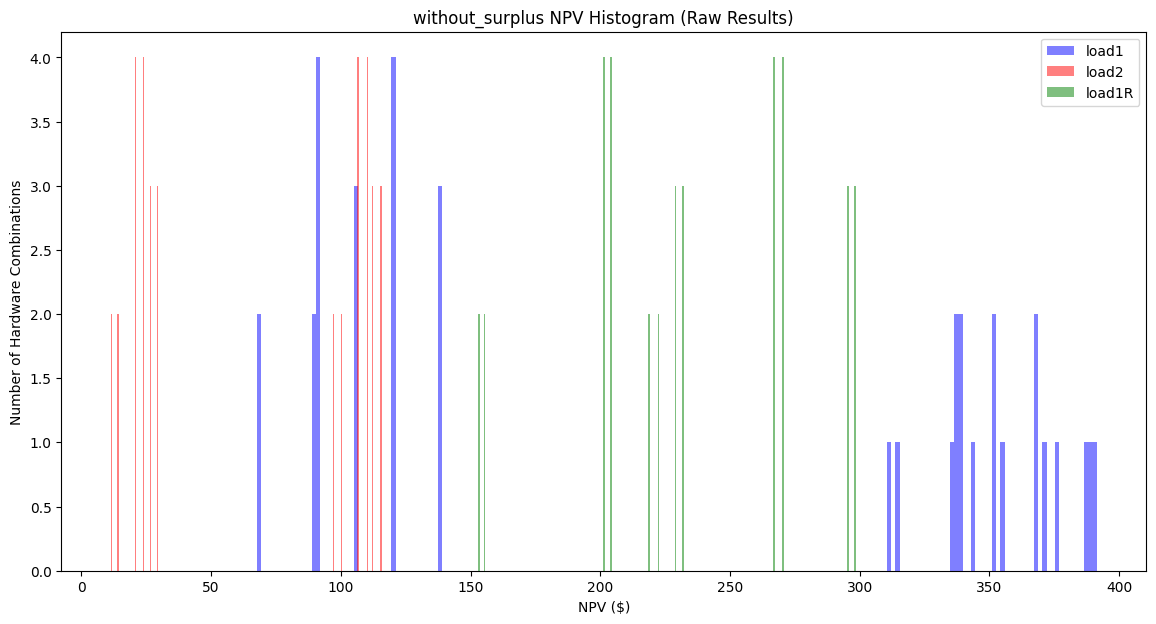

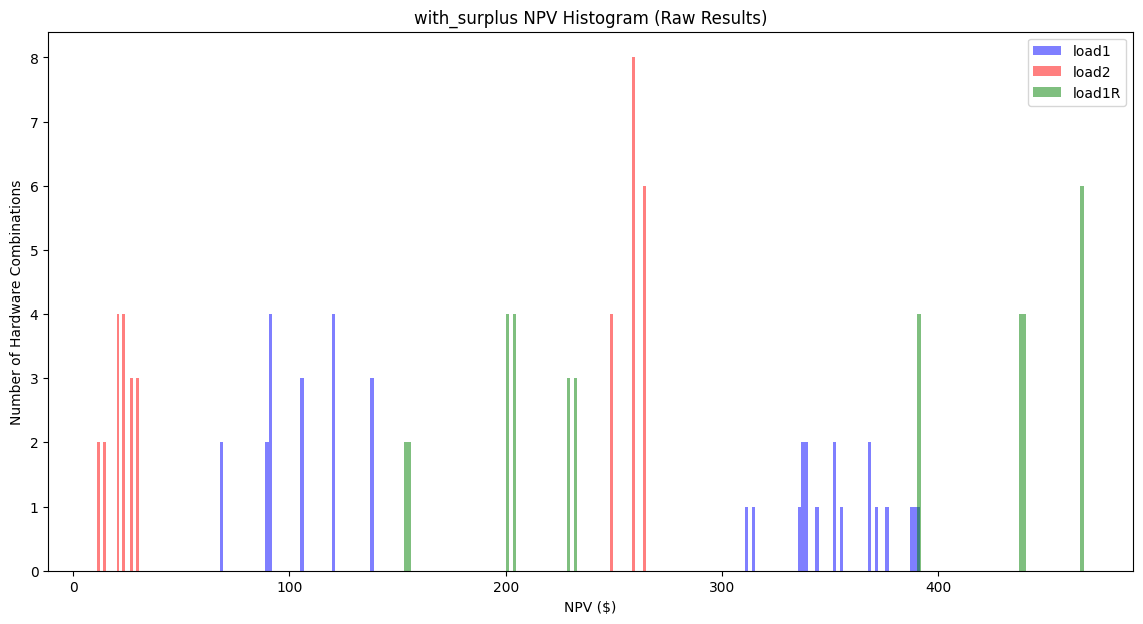

In [894]:
n = ['without_surplus','with_surplus']
for c in n:
    plt.figure(figsize=(14,7)) # Make it 14x7 inch
    #plt.style.use('seaborn-whitegrid') # nice and clean grid
    plt.hist(resultsNPV[resultsNPV[f'load1_NPV_{c}']<20000][f'load1_NPV_{c}'], bins=200, facecolor = 'blue',alpha=0.5, label='load1')
    plt.hist(resultsNPV[resultsNPV[f'load2_NPV_{c}']<20000][f'load2_NPV_{c}'], bins=200, facecolor = 'red',alpha=0.5, label='load2')
    plt.hist(resultsNPV[resultsNPV[f'load1R_NPV_{c}']<20000][f'load1R_NPV_{c}'], bins=200, facecolor = 'green',alpha=0.5, label='load1R')
    plt.title(f'{c} NPV Histogram (Raw Results)') 
    plt.xlabel('NPV ($)') 
    plt.legend()
    plt.ylabel('Number of Hardware Combinations') 
    plt.show()

## Filtering - PBP

In [527]:
# Plot PBP

cols = ['load1_PBP','load2_PBP','load1R_PBP']

resultsPBP = pd.DataFrame()
for c in cols:
    # Expand dict into columns
    expanded = results_df[c].apply(pd.Series)
    expanded = expanded.rename(columns={'gridValueEvents': f'{c}_gridValueEvents','gridValueDRSeason': f'{c}_gridValueDRSeason','gridValueAnnual': f'{c}_gridValueAnnual'})  
    #print(expanded)

    # Merge with original
    resultsPBP = pd.concat([resultsPBP, expanded.drop(columns=['gridDrawkWhDC'])], axis=1)

# if PBP is negative, its never reached
resultsPBP.head()

,load1_PBP_gridValueEvents,load1_PBP_gridValueDRSeason,load1_PBP_gridValueAnnual,load2_PBP_gridValueEvents,load2_PBP_gridValueDRSeason,load2_PBP_gridValueAnnual,load1R_PBP_gridValueEvents,load1R_PBP_gridValueDRSeason,load1R_PBP_gridValueAnnual
0,300.510564,-22.929783,-9.021326,300.510564,-22.929783,-9.021326,34.336792,-56.129975,-11.757397
1,245.471710,-32.097680,-11.802060,245.471710,-32.097680,-11.802060,31.618138,-277.679570,-17.489445
2,196.173942,-46.132211,-15.157995,196.173942,-46.132211,-15.157995,27.433633,103.335011,-28.886960
3,165.769519,-76.772120,-20.470990,165.769519,-76.772120,-20.470990,24.474782,45.870826,-71.307832
4,145.171791,-196.125858,-30.156390,145.171791,-196.125858,-30.156390,22.276005,30.391262,206.505179


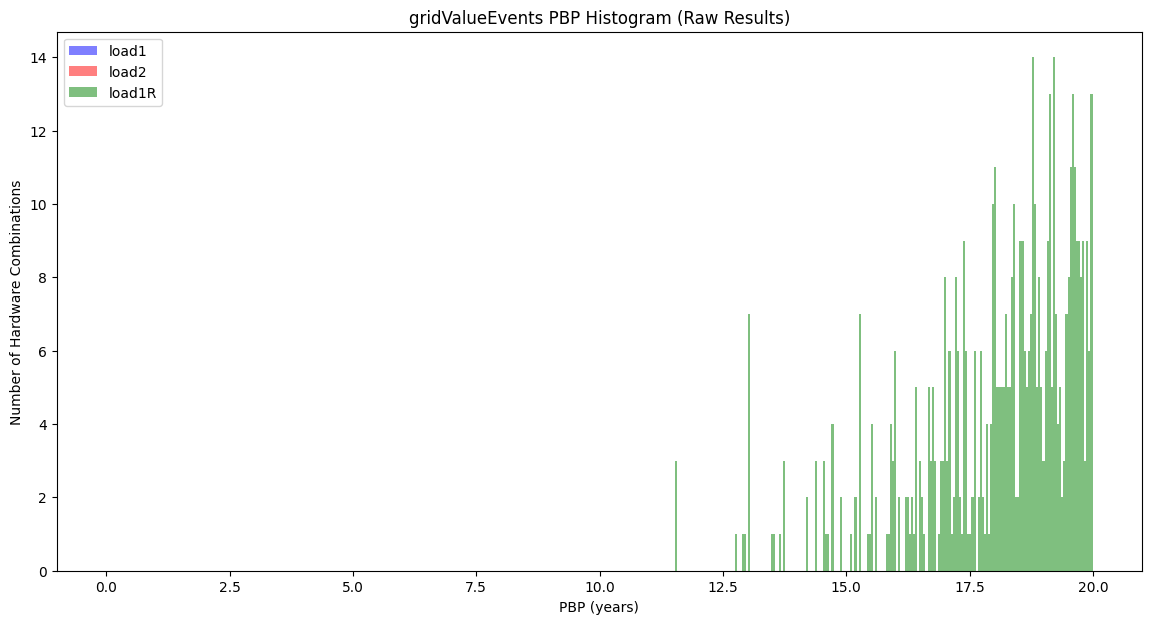

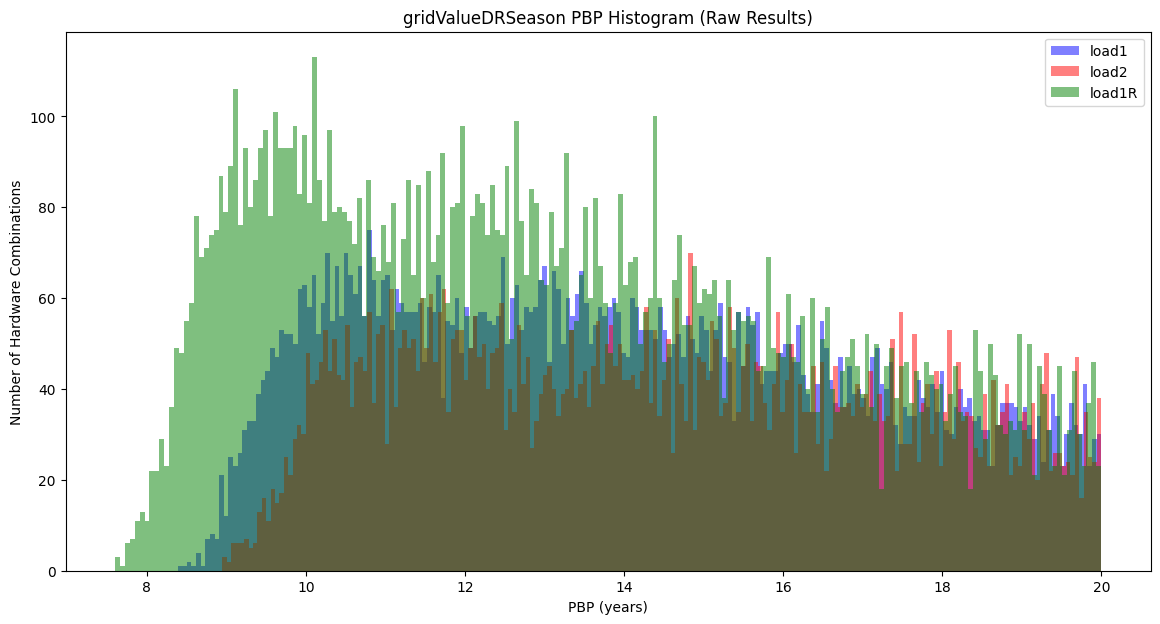

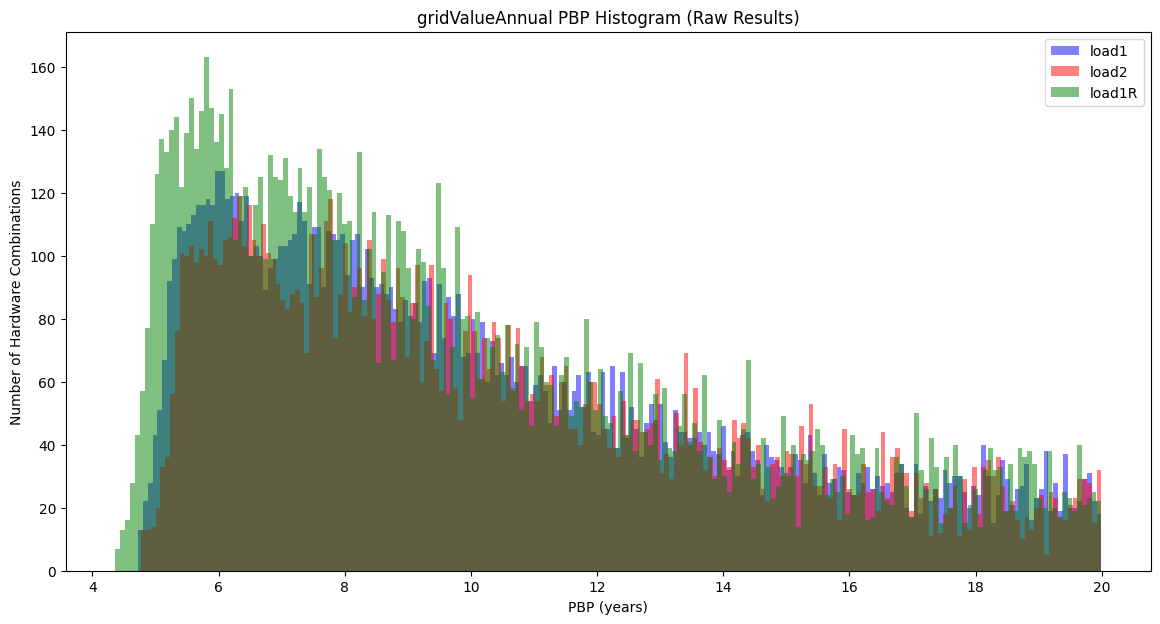

In [528]:
n = ['gridValueEvents','gridValueDRSeason', 'gridValueAnnual']
for c in n:
    plt.figure(figsize=(14,7)) # Make it 14x7 inch
    plt.hist(resultsPBP[(resultsPBP[f'load1_PBP_{c}']>= 0) & (resultsPBP[f'load1_PBP_{c}']<20)][f'load1_PBP_{c}'], bins=200, facecolor = 'blue',alpha=0.5, label='load1')
    plt.hist(resultsPBP[(resultsPBP[f'load2_PBP_{c}']>= 0) &(resultsPBP[f'load2_PBP_{c}']<20)][f'load2_PBP_{c}'], bins=200, facecolor = 'red',alpha=0.5, label='load2')
    plt.hist(resultsPBP[(resultsPBP[f'load1R_PBP_{c}']>=0) & (resultsPBP[f'load1R_PBP_{c}']<20)][f'load1R_PBP_{c}'], bins=200, facecolor = 'green',alpha=0.5, label='load1R')
    plt.title(f'{c} PBP Histogram (Raw Results)') 
    plt.xlabel('PBP (years)') 
    plt.ylabel('Number of Hardware Combinations') 
    plt.legend()
    plt.show()

# load event coverage percentage

In [529]:
# Plot PBP
cols = ['csrpLoad1_percentage', 'csrpLoad2_percentage','csrpLoad1replacement_percentage']

resultsPercentage = pd.DataFrame()
for c in cols:
    resultsPercentage[c] = results_df[c].apply(lambda x: np.mean(x) if isinstance(x, list) and x else np.nan)

resultsPercentage.head()

,csrpLoad1_percentage,csrpLoad2_percentage,csrpLoad1replacement_percentage
0,0.079396,0.396982,0.496228
1,0.093409,0.467044,0.583805
2,0.110972,0.554860,0.693576
3,0.128554,0.642771,0.803464
4,0.146122,0.730610,0.913263


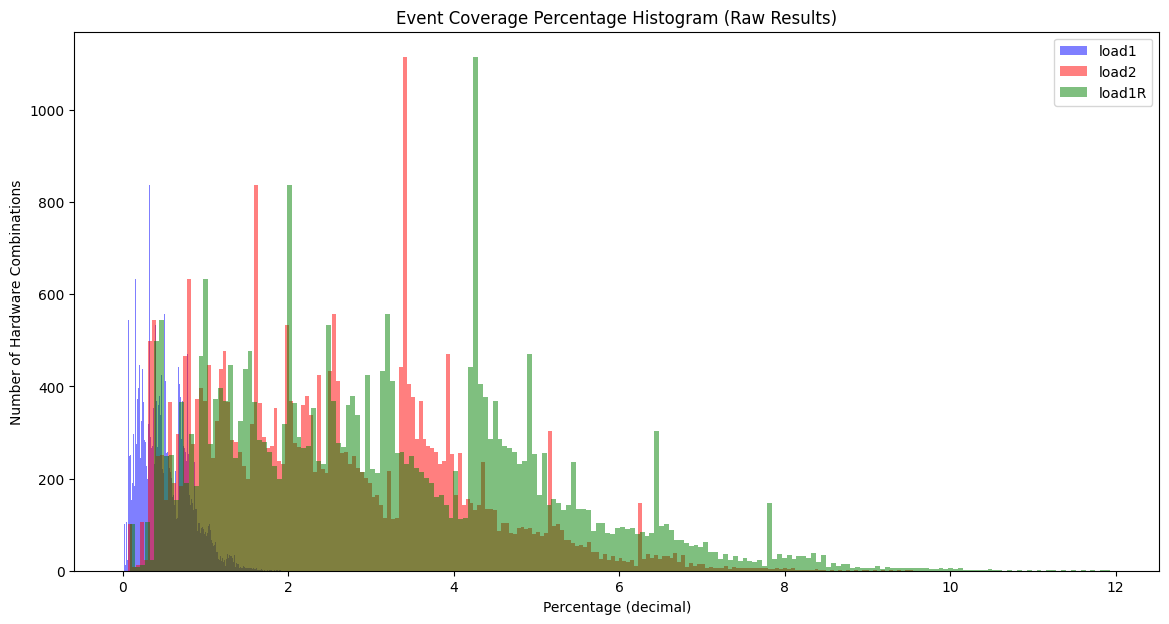

In [530]:
plt.figure(figsize=(14,7)) # Make it 14x7 inch
plt.hist(resultsPercentage[cols[0]], bins=200, facecolor = 'blue',alpha=0.5, label='load1')
plt.hist(resultsPercentage[cols[1]], bins=200, facecolor = 'red',alpha=0.5, label='load2')
plt.hist(resultsPercentage[cols[2]], bins=200, facecolor = 'green',alpha=0.5, label='load1R')
plt.title('Event Coverage Percentage Histogram (Raw Results)') 
plt.xlabel('Percentage (decimal)') 
plt.ylabel('Number of Hardware Combinations') 
plt.legend()
plt.show()

In [531]:
# #filter out anything with an PBP over its working years
# favPayback_df = results_df[results_df['PBP'] <= results_df['workingLife']] 

# favPayback_df_Z = favPayback_df[favPayback_df['immediateEventAmt'] == 0] 
# favPayback_df_O = favPayback_df[favPayback_df['immediateEventAmt'] == 1] 
# favPayback_df_F = favPayback_df[favPayback_df['immediateEventAmt'] == 5] 

# print('Total Combinations')
# print(str(favPayback_df.shape[0])+ ' total favorable PBP hardware combinations generated')
# print(str(favPayback_df_Z.shape[0])+ ' total favorable PBP hardware combinations generated - Zero Immediate Event')
# print(str(favPayback_df_O.shape[0])+ ' total favorable PBP hardware combinations generated - One Immediate Event')
# print(str(favPayback_df_F.shape[0])+ ' total favorable PBP hardware combinations generated - Five Immediate Event')

# print('Eastern')
# print(str(favPayback_df[favPayback_df['az']==110].shape[0])+ ' eastern favorable PBP hardware combinations generated')
# print(str(favPayback_df_Z[favPayback_df_Z['az']==110].shape[0])+ ' eastern favorable PBP hardware combinations generated - Zero Immediate Event')
# print(str(favPayback_df_O[favPayback_df_O['az']==110].shape[0])+ ' eastern favorable PBP hardware combinations generated - One Immediate Event')
# print(str(favPayback_df_F[favPayback_df_F['az']==110].shape[0])+ ' eastern favorable PBP hardware combinations generated - Five Immediate Event')

# print('Southern')
# print(str(favPayback_df[favPayback_df['az']==180].shape[0])+ ' southern favorable PBP hardware combinations generated')
# print(str(favPayback_df_Z[favPayback_df_Z['az']==180].shape[0])+ ' southern favorable PBP hardware combinations generated - Zero Immediate Event')
# print(str(favPayback_df_O[favPayback_df_O['az']==180].shape[0])+ ' southern favorable PBP hardware combinations generated - One Immediate Event')
# print(str(favPayback_df_F[favPayback_df_F['az']==180].shape[0])+ ' southern favorable PBP hardware combinations generated - Five Immediate Event')

# print('Western')
# print(str(favPayback_df[favPayback_df['az']==250].shape[0])+ ' westerm favorable PBP hardware combinations generated')
# print(str(favPayback_df_Z[favPayback_df_Z['az']==250].shape[0])+ ' westerm favorable PBP hardware combinations generated - Zero Immediate Event')
# print(str(favPayback_df_O[favPayback_df_O['az']==250].shape[0])+ ' westerm favorable PBP hardware combinations generated - One Immediate Event')
# print(str(favPayback_df_F[favPayback_df_F['az']==250].shape[0])+ ' westerm favorable PBP hardware combinations generated - Five Immediate Event')

## Filtering - PBP

In [412]:
# results_df['load1_PBP'].describe()

In [413]:
# favNPV_df = results_df[results_df['PBP']>=0]
# favNPV_df.describe()

In [414]:
# results_df['NPV'].describe()

In [415]:
# favNPV_df = results_df[results_df['NPV']>=0]
# favNPV_df.describe()